In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from analytical_functions import create_open_close_df, cm_and_classification_report, generateshortDateTimeStamp
from eda_functions import feature_importance_plot
from keras.utils import plot_model
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from contextlib import redirect_stdout
np.random.seed(90210)
tf.random.set_seed(90210)


Using TensorFlow backend.


Dividing the data to train and test-set, ~66.67% train and 33.33% test <br>
The data is scaled according to the train-set

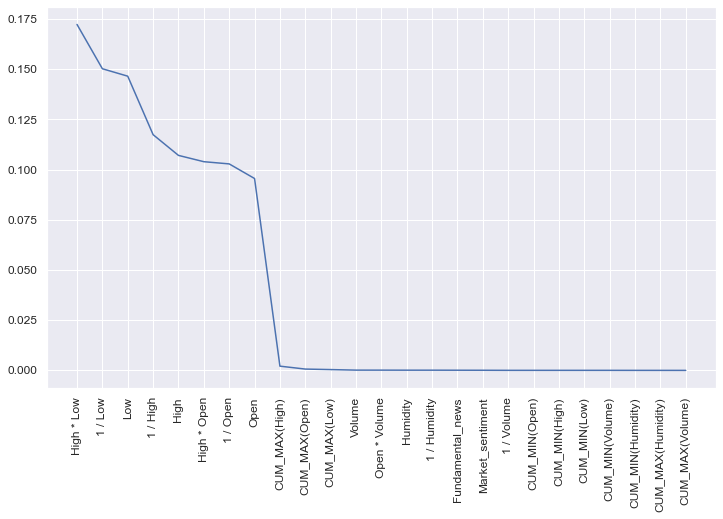

In [2]:
# Loading and scaling data
ts = generateshortDateTimeStamp()
feature_matrix_full = pd.read_csv('data/dfs/features.csv')
y = pd.read_csv('data/dfs/y_label.csv')

feature_importance = feature_importance_plot(feature_matrix_full[list(feature_matrix_full)[0:25]], y, to_show=True)
feature_matrix = feature_matrix_full.copy(deep=True)

n_features = len(list(feature_matrix))
n_rows_train = 1175
n_rows_test = 588

x_train = feature_matrix.head(n_rows_train).copy(deep=True)
y_train_series = y.head(n_rows_train).copy(deep=True)

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(x_train)
scaler_target = MinMaxScaler(feature_range=(-1, 1))
scaler_target.fit(y_train_series.values)

x_train_scaled = scaler.transform(x_train)
y_train_scaled = scaler_target.transform(y_train_series.values)

Used <b>featuretools</b> for automatic feature generation, and used a <b>tree-based</b> algorithm to estimate <b>feature importance</b><br>
I've trained the model with full and partial features-set according to the importance. <br>
Even when using fewer features, the model still gets good results.<br>
The <b>featuretools</b> script is in a different file to make reading easier

In [3]:
##########################################################################################
# LSTM - preparing dataset
##########################################################################################
epochs = 10
look_back = 10
# epochs = 20
# look_back = 30
batch_size = 50
X_train = []
y_train_as_arr = y_train_scaled.ravel()
y_train = []
for i in range(look_back, n_rows_train):
    X_train.append(x_train_scaled[i - look_back:i])
    y_train.append(y_train_as_arr[i])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_features))


Preparing the dataset for LSTM (both train and labels) using look_back parameter to determine the number <br>
of states back our model will consider

Epoch 1/10
1165/1165 [==============================] - 4s 3ms/step - loss: 0.0508
Epoch 2/10
1165/1165 [==============================] - 2s 2ms/step - loss: 0.0197A: 0s - loss: 0.019
Epoch 3/10
1165/1165 [==============================] - 2s 2ms/step - loss: 0.0176
Epoch 4/10
1165/1165 [==============================] - 2s 2ms/step - loss: 0.0168
Epoch 5/10
1165/1165 [==============================] - 2s 2ms/step - loss: 0.0149
Epoch 6/10
1165/1165 [==============================] - 2s 2ms/step - loss: 0.0164
Epoch 7/10
1165/1165 [==============================] - 2s 2ms/step - loss: 0.0141
Epoch 8/10
1165/1165 [==============================] - 2s 2ms/step - loss: 0.0115
Epoch 9/10
1165/1165 [==============================] - 2s 2ms/step - loss: 0.0119
Epoch 10/10
1165/1165 [==============================] - 2s 2ms/step - loss: 0.0127


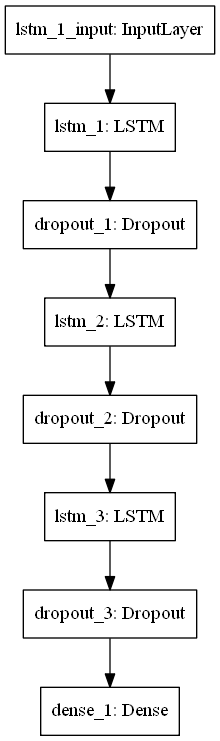

In [4]:
##########################################################################################
# LSTM Model
##########################################################################################
regressor = Sequential()
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], n_features)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences=True, activation='relu'))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=25))
regressor.add(Dropout(0.2))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam', loss='mean_squared_error')

regressor.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
# Always save model architecture
plot_model(regressor, to_file=f'output/{ts}_model.png')

Visualizing the results of price prediction on the training set

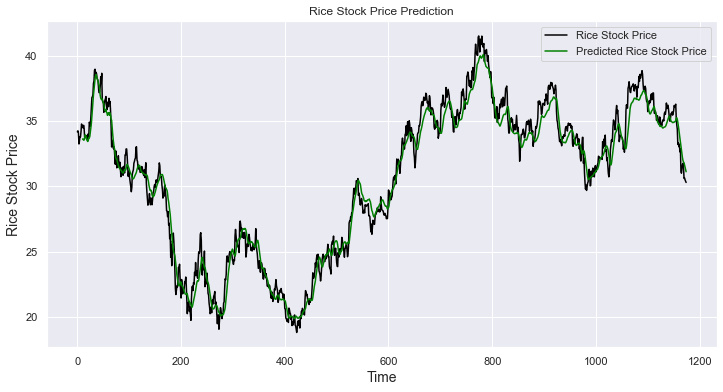

In [7]:
##########################################################################################
# Train stock price visualization
##########################################################################################
predicted_train_scaled_stock_price = regressor.predict(X_train, batch_size=batch_size)
predicted_train_stock_price = scaler_target.inverse_transform(predicted_train_scaled_stock_price)

plt.figure(figsize=(12, 6))
plt.plot(range(0, len(y_train_series)), y_train_series.values, color='black', label='Rice Stock Price')
plt.plot(range(look_back, len(predicted_train_stock_price)+look_back), predicted_train_stock_price, color='green', 
         label='Predicted Rice Stock Price')
plt.title('Rice Stock Price Prediction')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rice Stock Price', fontsize=14)
plt.legend()
plt.show()

Our model very closely predicts the prices, though this can also be overfitting. <br>
We'll look at the prediction on the test set to verify our results

Preparing test-set data in a similar way to the train set

In [8]:
##########################################################################################
# Test
##########################################################################################
feature_matrix_scaled = scaler.transform(feature_matrix)
inputs = feature_matrix_scaled[len(feature_matrix_scaled) - n_rows_test - look_back:]

X_test = []
for i in range(look_back, n_rows_test):
    X_test.append(inputs[i-look_back:i])
x_test = np.array(X_test)

And predicting...

In [10]:
predicted_test_scaled_stock_price = regressor.predict(x_test, batch_size=batch_size)
predicted_test_stock_price = scaler_target.inverse_transform(predicted_test_scaled_stock_price)
y_test_series = y.tail(n_rows_test).copy(deep=True)
y_test = y_test_series.values.ravel()

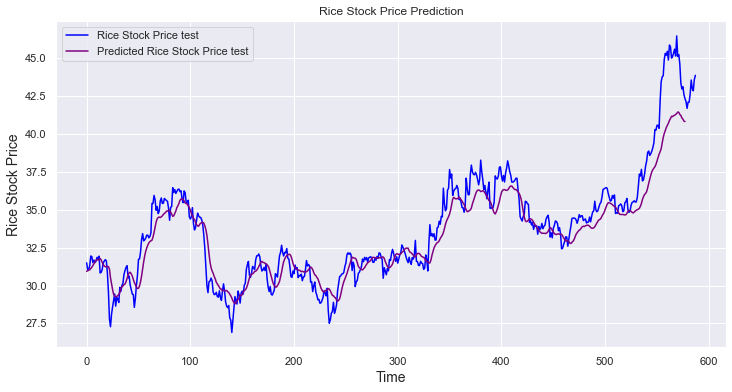

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(range(0, len(y_test)), y_test, color='blue', label='Rice Stock Price test')
plt.plot(range(0, len(predicted_test_stock_price)), predicted_test_stock_price.ravel(), color='purple', 
         label='Predicted Rice Stock Price test')
plt.title('Rice Stock Price Prediction')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Rice Stock Price', fontsize=14)
plt.legend()
plt.show()

Awesome :) Our model appears to have captured the main trends quite accurately!

From this point of view it seems that the model is handling the data very well.<br>
The main trends are very closely tracked, with a small range of error, but...! <br>
Is predicting the price accurately the appropriate measurement? <br>
<br>
The truth is, that from a business point of view it might be more useful to know if the stock<br>
is going <b>up</b> or <b>down</b>. The is, if we can predict that the stock will <b>CLOSE</b> at<br>
a higher rate than its <b>OPENING</b> price, it would have an immense business value. We would <br>
probably buy the stock, and sell the next day. Or have any number of long/short term strategies <br>
<br>
Moreover, this reveals the weakness in using <b>MAE</b> for prediction. What if we predicted <br>
the prices <i>almost</i> accurately? By "almost" I mean, that we might get the trend wrong.<br>
Predict up, when the stock is going down, and vise-versa. In such a scenario, even if we <br>
prected a very close price, we'll end up losing money all the time.<br>

Therefore, I selected to use (<b>CLOSE</b>-<b>OPEN</b> > thr) price as a categorical target. <b>thr</b><br>
is a sort of profitability margin. If the stock goes up, but only by very little, then it might <br>
be unprofitable to buy due to the overhead around buying and selling (fees, taxes, etc.)<br>
For the simplicity of this assignment, thr = 0, but it can be easily changed

<br>Here we'll be calculating both <b>MAE</b> and <b>categorical</b> variables and inspect them for<br>
both train and test sets

In [12]:
test_original_features: pd.DataFrame = feature_matrix_full.tail(n_rows_test - look_back).copy(deep=True)
train_binary_class_df = create_open_close_df(x_train['Open'].values[look_back:], y_train_series.values.ravel()[look_back:], 
                                             predicted_train_stock_price.ravel())
test_binary_class_df = create_open_close_df(test_original_features['Open'].values, y_test.ravel()[:-look_back], 
                                            predicted_test_stock_price.ravel())

mae_train = mean_absolute_error(y_train_series.values[look_back:], predicted_train_scaled_stock_price)
mae_test = mean_absolute_error(y_test[:-look_back], predicted_test_stock_price)

Writing results to file and printing them to console

In [13]:
fname = 'output/' + ts + '.txt'
with open(fname, 'w') as f:
    with redirect_stdout(f):
        print("TRAIN")
        cm_and_classification_report(train_binary_class_df['hasStockGoneUp'].values, 
                                     train_binary_class_df['hasStockGoneUp_pred'].values, labels=[0, 1])
        print("TEST")
        cm_and_classification_report(test_binary_class_df['hasStockGoneUp'].values, 
                                     test_binary_class_df['hasStockGoneUp_pred'].values, labels=[0, 1])
        print(f"\nlook_back:\t{look_back}")
        print(f"batch_size:\t{batch_size}")
        print(f"epochs:\t{epochs}")
        print("Train MAE: %.3f" % mae_train)
        print("Test MAE: %.3f" % mae_test)
f.close()
with open(fname, 'r') as f:
    print(f.read())
f.close()


TRAIN
     t/p      0     1 
        0   375   220 
        1   333   237 

              precision    recall  f1-score   support

       False      0.530     0.630     0.576       595
        True      0.519     0.416     0.462       570

    accuracy                          0.525      1165
   macro avg      0.524     0.523     0.519      1165
weighted avg      0.524     0.525     0.520      1165

TEST
     t/p      0     1 
        0   273    30 
        1    77   198 

              precision    recall  f1-score   support

       False      0.780     0.901     0.836       303
        True      0.868     0.720     0.787       275

    accuracy                          0.815       578
   macro avg      0.824     0.810     0.812       578
weighted avg      0.822     0.815     0.813       578


look_back:	10
batch_size:	50
epochs:	10
Train MAE: 30.682
Test MAE: 0.934



Using <b>hasStockGoneUp</b> we would aim to know, for most of the time, if the stock is about to go up, or not<br>
and to some extent by how much (using the <b>thr</b> parameter)<br>
The results of such a categorical approach gives good results. 
To this point, I must apologize: I suspect very much that there's a small <b>bug</b> <br>
in the train-categorical predictions, probably a shift of the <b><i>look_back</i></b> parameter,<br>
but I hadn't had the time to find it. My apologies<br>
The results in the test-set as well as the graphs have good starting recall values, but can <br>
be improved upon, with more time